In [1]:
import random
import json 
import time
import copy

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold

import torch

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, ConcatDataset
import torch.optim as optim
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR

from torchvision import models
from torchsummary import summary

# !pip install transformers
import transformers
from transformers import BertTokenizer, BertModel, BertConfig, AdamW

import matplotlib.pyplot as plt
import seaborn as sns

#from apex import amp

# ensure reproducability
#torch.seed(25)
torch.manual_seed(25)
torch.cuda.manual_seed_all(25)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(25)
random.seed(25)



In [2]:
# Initialization
#opt_level = 'O1'
#apex.amp.initialize(model, optimizer, opt_level=opt_level)

#torch.cuda.amp.GradScaler(
#    init_scale=65536.0, growth_factor=2.0, backoff_factor=0.5,
#    growth_interval=2000, enabled=True
# )


In [3]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
#device = 'cuda'

In [4]:
print('Model will be trained on: ' + device)

Model will be trained on: cuda


source
https://colab.research.google.com/drive/1d8N-ZLDS4FcmBDDG19gxbt_lSKglnwKq#scrollTo=mgX-jLdjw3Hl <br>
https://github.com/kaushaltrivedi/bert-toxic-comments-multilabel/blob/master/toxic-bert-multilabel-classification.ipynb

<br>
optimized with: <br>
https://pytorch.org/docs/stable/notes/amp_examples.html

<br>
Additional info <br>
https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

In [5]:
#df = pd.read_csv("./data/train.csv")
#df['list'] = df[df.columns[2:]].values.tolist()
#new_df = df[['comment_text', 'list']].copy()
#new_df.head()

In [6]:
def extract_json_object(filename):
    with open(file, "r", encoding='utf-8') as read_file:
        json_array = json.load(read_file)
    json_data = []    
    #parse the data
    for item in json_array:
        details = {"id":None, "labels":None, "text":None}
        details['id'] = item['id']
        try: 
            details['labels'] = item['labels']
        except KeyError: 
            details['labels'] = []         
        details['text'] = item['text']
        json_data.append(details)

    
    return json_data






In [7]:
# file paths
lst_file_path=[]

lst_file_path.append("../data/training_data_task3.txt")

lst_file_path.append("../data/validation_data_task3.txt")


# List of keys 
dataset = ["training", "validation"] 
# empty dictionary
dic_datasets =  dict.fromkeys(dataset, pd.DataFrame()) 


In [8]:
for i, file in enumerate(lst_file_path):
    print('loading'+ file)
    dic_datasets[dataset[i]] = pd.DataFrame(extract_json_object(extract_json_object))

loading../data/training_data_task3.txt
loading../data/validation_data_task3.txt


In [9]:
df_training = pd.DataFrame(dic_datasets['training'][['id','labels','text']])
df_training.labels = df_training.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)

df_val = pd.DataFrame(dic_datasets['validation'][['id','labels','text']])
df_val.labels = df_val.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)


In [10]:
print('average sentence length: ', df_training.text.str.split().str.len().mean())
print('stdev sentence length: ', df_training.text.str.split().str.len().std())

average sentence length:  18.264099037138926
stdev sentence length:  11.755503545808766


In [11]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 20
freeze_layer_count = 11
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 5

#LEARNING_RATE = 1e-05
LEARNING_RATE = None
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# kfold Configuration options
k_folds = 10
  
# For fold results
results = {}


BERT input representation. The input embeddings are the sum of the token embeddings, the segmentation embeddings and the position embeddings. <br>
The first token of every sequence is always a special clas- sification token ([CLS]). <br>
The final hidden state corresponding to this token is used as the ag- gregate sequence representation for classification tasks. Sentence pairs are packed together into a single sequence. <br>
We differentiate the sentences in two ways. First, we separate them with a special token ([SEP]). Second, we add a learned embed- ding to every token indicating whether it belongs to sentence A or sentence B. <br>
A positional embedding is also added to each token to indicate its position in the sequence. <br>
We are required to: <br>
Add special tokens to the start and end of each sentence. <br>
Pad & truncate all sentences to a single constant length. <br>
Explicitly differentiate real tokens from padding tokens with the “attention mask”. <br>

[SEP] <br>
At the end of every sentence, we need to append the special [SEP] token. <br>
This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?).<br>
Here we are not certain yet why the token is still required when we have only single-sentence input, but it is! <br>
[CLS]<br>
For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.<br>

For classification tasks, we must prepend the special [CLS] token to the beginning of every sentence.
This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).
On the output of the final (12th) transformer, only the first embedding (corresponding to the [CLS] token) is used by the classifier.
“The first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks.”
Also, because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector.

In [12]:
# note: a gelu hidden activation function is being used

In [13]:

# Initializing a BERT bert-base-uncased style configuration
configuration = BertConfig(vocab_size=30522, hidden_size=768, num_hidden_layers=12, num_attention_heads=12, 
                           intermediate_size=3072, hidden_act='gelu', 
                           hidden_dropout_prob=0.1, attention_probs_dropout_prob=0.1, 
                           max_position_embeddings=512, type_vocab_size=2, initializer_range=0.02, 
                           layer_norm_eps=1e-12, pad_token_id=0, 
                           gradient_checkpointing=False, position_embedding_type='absolute', use_cache=True)



In [14]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.text
        self.targets = self.data[[
                                    'Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    'Misrepresentation of Someone\'s Position (Straw Man)',
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Whataboutism',
                                    'Bandwagon',
                                    'Transfer',
                                    'Appeal to (Strong) Emotions'
                                ]].to_numpy()
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        #print(index)
        #print(self.comment_text.index)
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        # inputs = self.tokenizer.encode_plus(
        #    comment_text,
        #    None,
        #    add_special_tokens=True,
        #    truncation=True,
        #    max_length=self.max_len,
        #    pad_to_max_length=True,
        #    #padding=True,
        #    #padding='longest',
        #    return_token_type_ids=True
        # )
        inputs = tokenizer.encode_plus(
                    comment_text, 
                    add_special_tokens = True,    
                    truncation = True, 
                    max_length=self.max_len,
                    padding = "max_length", 
                    return_attention_mask = True, 
                    #return_tensors = "pt"
                    return_token_type_ids=True
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
Initializing a model from the bert-base-uncased style configuration

In [15]:
class BertClass(transformers.PreTrainedModel):
    def __init__(self, config):
        super(BertClass, self).__init__(config)
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.5)
        self.l3 = torch.nn.Linear(768, 22)
    #768
    def forward(self, ids, mask, token_type_ids):
        #print(ids)
        #print(mask)
        #_,
        #print(type(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids)))
        #print(self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids))
        
        # transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions -> out of self.l1, need the tensor poooler_output
        output_1= self.l1(input_ids =ids, attention_mask = mask, token_type_ids = token_type_ids).pooler_output
        
        #print(output_1)
        #print(type(output_1))
        #print(_)
        #print(type(_))
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output




Text - Pre-Processing

Use the multilabelbinarizaer to convert the 'words' for the dependent variable (y) to a numerical representation (dummy vars)

In [16]:
mlb = MultiLabelBinarizer(sparse_output=True)

df_concat_labels = pd.concat([df_training.pop('labels'), df_val.pop('labels')])
concat_labels = df_training.join(pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df_concat_labels),
                    index=df_concat_labels.index,
                    columns=mlb.classes_))


df_training = concat_labels[0:len(df_training)]
df_training.reset_index(inplace=True)

df_val = concat_labels[len(df_training):]
df_val.reset_index(inplace=True)

In [17]:
test =pd.DataFrame.reset_index(pd.concat([df_training, df_val]), drop=True)

Recombine data set to allow for Kfold Cross Validation

In [18]:
df_combined = pd.DataFrame.reset_index(pd.concat([df_training, df_val]), drop=True)


#dataset = ConcatDataset([df_training, df_val])
  
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

In [19]:
print(kfold)

KFold(n_splits=10, random_state=None, shuffle=True)


In [20]:
print("Combined Dataset: {}".format(len(df_combined)))

Combined Dataset: 867


In [21]:
# Creating the dataset and dataloader for the neural network

#train_size = 0.8

#new_df2 = new_df[1:200]
#train_dataset=df_training
#test_dataset=df_val
#train_dataset = train_dataset.reset_index(drop=True)


#print("FULL Dataset: {}".format(df_concat_labels.shape))
#print("TRAIN Dataset: {}".format(train_dataset.shape))
#print("TEST Dataset: {}".format(test_dataset.shape))

#training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
#testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)


#dataset_size = len(train_dataset)

In [22]:
#train_params = {'batch_size': TRAIN_BATCH_SIZE,
#                'shuffle': True,
#                'num_workers': 0
#                }

#test_params = {'batch_size': VALID_BATCH_SIZE,
#                'shuffle': True,
#                'num_workers': 0
#                }

#training_loader = DataLoader(training_set, **train_params)
#testing_loader = DataLoader(testing_set, **test_params)

why this loss function was selected:
nn.CrossEntropyLoss uses the target to index the logits in your model’s output.<br>
Thus it is suitable for multi-class classification use cases (only one valid class in the target). <br>

nn.BCEWithLogitsLoss on the other hand treats each output independently and is suitable for multi-label classification use cases.<br>

In [23]:
#helper functions

def create_data_loader_kfold(df, trn_ids, tst_ids):
    cust_Dataset = CustomDataset(df, tokenizer, MAX_LEN)
    
    #for idx, (data) in enumerate(cust_Dataset):
    #    print(idx)

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(trn_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(tst_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      cust_Dataset, 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      cust_Dataset,
                      batch_size=10, sampler=test_subsampler)
    
    dataset_size = len(trainloader)

    print("TRAIN Dataset: {}".format(len(trainloader)))
    print("TEST Dataset: {}".format(len(testloader)))
    
    return trainloader, testloader, dataset_size    
    
    
    

def create_data_loader(train_dataset,test_dataset):
    print("TRAIN Dataset: {}".format(train_dataset.shape))
    print("TEST Dataset: {}".format(test_dataset.shape))
    
    training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
    testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
    dataset_size = len(train_dataset)
    
    train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

    test_params = {'batch_size': VALID_BATCH_SIZE,
                    'shuffle': True,
                    'num_workers': 0
                    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)


    return training_loader, testing_loader, dataset_size

def instantiate_model(config, lock_layer_count):
    model = BertClass(config)
    # Accessing the model configuration
    configuration = model.config

    #freeze model
    if lock_layer_count:
    # We freeze here the embeddings of the model
        for param in model.l1.embeddings.parameters():
            param.requires_grad = False

        if lock_layer_count != -1:
            # if freeze_layer_count == -1, we only freeze the embedding layer
            # otherwise we freeze the first `freeze_layer_count` encoder layers
            for layer in model.l1.encoder.layer[:lock_layer_count]:
                for param in layer.parameters():
                    param.requires_grad = False

    # view layers                
    #for name, param in model.named_parameters():
        #print(name)
    #    if param.requires_grad:
    #        print(name)

    # learnable parameters
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total Learnable Parms: " + str(pytorch_total_params))
    
    return model, configuration


# contains a sigmoids activation function built in.
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)



In [51]:
# count of leaarnable paramaters for model

In [24]:
model, configuration = instantiate_model(configuration,freeze_layer_count)

Total Learnable Parms: 7695382


In [ ]:
#send model to device

In [25]:
model.to(device)

BertClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [26]:
#model.l1.embeddings

In [27]:
#model.l1.encoder

In [53]:
# view model convifurationprint

(model.config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [29]:
# original optimizer

In [30]:
#optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

replaced adam optimizatizer with Adafactor -> better designed for BERT
https://arxiv.org/pdf/1804.04235.pdf

In [31]:
# replace AdamW with Adafactor

optimizer = transformers.Adafactor(
    model.parameters(),
    lr=LEARNING_RATE,  # when using warm up and relative step, LR is auto determined
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.82, #0.8
    beta1=None, # <- used for L1 regularization
    weight_decay=0.0002, # L2 regularization, to prevent overfitting  (beta2)
    relative_step=True,
    scale_parameter=False,
    warmup_init=True
)

In [32]:
#for param_group in optimizer.param_groups:
#    print(param_group['lr'])
    
#LambdaLR.get_last_lr(optimizer)



In [33]:
def train_model(model, trn_loader, tst_loader, dataset_size, optimizer, num_epochs=5):
    scaler = torch.cuda.amp.GradScaler() # used to minimize model footprint, strategy is called model quantitization.
    #model.train()
    torch.cuda.empty_cache()
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    losses_train = []
    losses_val = []
    accuracy_train = []
    accuracy_val= []
    

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = trn_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = tst_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for _, data in enumerate(loader):
                # zero the parameter gradients
                optimizer.zero_grad()
                
                #input into model (takes 3 items: ids, mask and token)
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            
                # gold label
                labels = data['targets'].to(device)

                
                # forward
                # track history if only in train                
                with torch.cuda.amp.autocast():  # used to minimize model footprint, strategy is called model quantitization.
                    #print('id')
                    #print(ids)
                    #print('mask')
                    #print(mask)
                    #print('token')
                    #print(token_type_ids)
                    preds = model(ids, mask, token_type_ids)
                    #print('pred')
                    #print(preds)
                    loss = loss_fn(preds, labels)
                    #print('loss')
                    #print(loss)
                    #preds = preds.detach().cpu().numpy()
                    
 
                    
                    # backward + optimize only if in training phase
                if phase == 'train':
                    scaler.scale(loss).backward() # used to minimize model footprint, strategy is called model quantitization.
                    scaler.step(optimizer)
                    scaler.update()

                # statistics
                running_loss += loss.detach().cpu().numpy() * ids.size(0)
                #print(running_loss)
                running_corrects += torch.sum(preds.data == labels.data)
                
                

                #print(running_corrects)
               # print(preds.detach().cpu().numpy())
                #print(labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            if phase == 'train':
                losses_train.append(epoch_loss) 
                accuracy_train.append(epoch_acc)
            else:
                losses_val.append(epoch_loss)
                accuracy_val.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    
        
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, "./model.pkl")
    return model, losses_train, losses_val, accuracy_train, accuracy_val

In [34]:
#train(10)

In [35]:
#train(epoch)
#train(2)


#model, loss_train, loss_val = train_model(model, optimizer, num_epochs=EPOCHS)

In [36]:
#plt.figure()
#plt.plot(loss_train)
#plt.plot(loss_val)

In [37]:
 #torch.cuda.empty_cache()

In [38]:


  # K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(df_combined)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    #trainloader = torch.utils.data.DataLoader(
    #                  dataset, 
    #                  batch_size=10, sampler=train_subsampler)
    #testloader = torch.utils.data.DataLoader(
    #                  dataset,
    #                  batch_size=10, sampler=test_subsampler)
    torch.cuda.empty_cache()
    
    trainloader, testloader, dataset_size = create_data_loader_kfold(df_combined,train_ids,test_ids)
    
    # Init the neural network
    #network = SimpleConvNet()
    
    # Initialize optimizer
    #optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    
    
    model, loss_train, loss_val, accuracy_train,accuracy_val = train_model(model, trainloader,testloader,dataset_size, optimizer, num_epochs=EPOCHS)
  
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
   # print('Starting testing')
    
    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    #with torch.no_grad():

      # Iterate over the test data and generate predictions
      #for i, data in enumerate(testloader, 0):

        # Get inputs
       # inputs, targets = data

        # Generate outputs
        #outputs = network(inputs)

        # Set total and correct
       # _, predicted = torch.max(outputs.data, 1)
       # total += targets.size(0)
       # correct += (predicted == targets).sum().item()
    
    #true_labels, true_bools, pred_labels = validation(model, testloader)

    #correct = len(true_bools)
    #total = len(true_labels)
    #print(loss_val)
    # Print accuracy
    #print('Accuracy for fold %d: %d %%' % (fold, 100.0 * loss_val))
    #print('--------------------------------')
    #results[fold] = 100.0 * loss_val
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
#sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum(accuracy_val)/len(accuracy_val)} %')


FOLD 0
--------------------------------
TRAIN Dataset: 78
TEST Dataset: 9
Epoch 0/9
--------------------


D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\transformers\optimization.py:557: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


train Loss: 5.4952 Acc: 0.0000
val Loss: 0.3256 Acc: 0.0000
Training complete in 0m 6s
Best val Acc: 0.000000
Epoch 1/9
--------------------
train Loss: 3.6470 Acc: 0.0000
val Loss: 0.3043 Acc: 0.0000
Training complete in 0m 12s
Best val Acc: 0.000000
Epoch 2/9
--------------------
train Loss: 3.2350 Acc: 0.0000
val Loss: 0.3031 Acc: 0.0000
Training complete in 0m 18s
Best val Acc: 0.000000
Epoch 3/9
--------------------
train Loss: 3.0889 Acc: 0.0000
val Loss: 0.3035 Acc: 0.0000
Training complete in 0m 24s
Best val Acc: 0.000000
Epoch 4/9
--------------------
train Loss: 3.0344 Acc: 0.0000
val Loss: 0.3005 Acc: 0.0128
Training complete in 0m 30s
Best val Acc: 0.012821
Epoch 5/9
--------------------
train Loss: 2.6845 Acc: 0.0128
val Loss: 0.2987 Acc: 0.0000
Training complete in 0m 36s
Best val Acc: 0.012821
Epoch 6/9
--------------------
train Loss: 2.7065 Acc: 0.0000
val Loss: 0.2936 Acc: 0.0000
Training complete in 0m 42s
Best val Acc: 0.012821
Epoch 7/9
--------------------
train L

In [39]:
dataset

['training', 'validation']

In [44]:
def validation(model, testing_loader):
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    #track variables
    true_labels,pred_labels = [],[]

    # Predict
    for _, data in enumerate(testing_loader, 0):
        #print(_)
        
        #prepare data to feed into model
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
       
        with torch.no_grad():
            
            # Forward pass
            outputs = model(ids, mask, token_type_ids)
            b_logit_pred = outputs
            pred_label = b_logit_pred

            b_logit_pred = b_logit_pred.detach().cpu().numpy()
            pred_label = pred_label.to('cpu').numpy()
            targets = targets.to('cpu').numpy()

        #tokenized_texts.append(b_input_ids)
        #logit_preds.append(b_logit_pred)
        true_labels.append(targets)
        pred_labels.append(pred_label)

    # Flatten outputs
    #tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
    # print(true_labels)
    # print(pred_labels)
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    # Converting flattened binary values to boolean values
    true_bools = [tl==1 for tl in targets]
    
    return true_labels, true_bools, pred_labels

In [45]:
dataset_tr, dataset_val, tr_size = create_data_loader(df_training, df_val)

TRAIN Dataset: (727, 26)
TEST Dataset: (140, 26)


In [42]:
col =  ['Appeal to authority',
                                    'Appeal to fear/prejudice',
                                    'Black-and-white Fallacy/Dictatorship',
                                    'Causal Oversimplification',
                                    'Doubt',
                                    'Exaggeration/Minimisation',
                                    'Flag-waving',
                                    'Glittering generalities (Virtue)',
                                    'Loaded Language',
                                    'Misrepresentation of Someone\'s Position (Straw Man)',
                                    'Name calling/Labeling',
                                    'Obfuscation, Intentional vagueness, Confusion',
                                    'Presenting Irrelevant Data (Red Herring)',
                                    'Reductio ad hitlerum',
                                    'Repetition',
                                    'Slogans',
                                    'Smears',
                                    'Thought-terminating cliché',
                                    'Whataboutism',
                                    'Bandwagon',
                                    'Transfer',
                                    'Appeal to (Strong) Emotions']
col2 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,21]

In [47]:
#for epoch in range(EPOCHS):
targets, target_labels, outputs = validation(model, dataset_val)
#targets, outputs = validation()

targets = targets
target_labels = target_labels
outputs = outputs 

outputs = [pl>0.50 for pl in outputs] #boolean output after thresholding

#print(outputs)
#print(target_labels)
#print(targets)

#outputs = np.array(outputs) >= 0.5
#targets = np.array(targets) >= 0.5
#outputs = np.argmax(outputs, axis=1)
#targets = np.argmax(targets, axis=1)

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro',zero_division=1)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division=1)
#print(f"epoch = {epoch}")
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
    
ml_cm = metrics.multilabel_confusion_matrix(targets,outputs, labels=col2)


Accuracy Score = 0.1
F1 Score (Micro) = 0.3622641509433962
F1 Score (Macro) = 0.08616670685636203


In [48]:
print(metrics.classification_report(targets, outputs, target_names = col,
                                    digits=2, output_dict=False,zero_division=1))

                                                     precision    recall  f1-score   support

                                Appeal to authority       1.00      0.00      0.00         6
                           Appeal to fear/prejudice       1.00      0.00      0.00        17
               Black-and-white Fallacy/Dictatorship       1.00      0.00      0.00         2
                          Causal Oversimplification       1.00      0.00      0.00         7
                                              Doubt       1.00      0.00      0.00        17
                          Exaggeration/Minimisation       1.00      0.00      0.00        13
                                        Flag-waving       1.00      0.00      0.00        13
                   Glittering generalities (Virtue)       1.00      0.00      0.00        11
                                    Loaded Language       1.00      0.05      0.10        74
Misrepresentation of Someone's Position (Straw Man)       1.00      0

In [49]:
type(ml_cm)
print(ml_cm)

[[[134   0]
  [  6   0]]

 [[123   0]
  [ 17   0]]

 [[138   0]
  [  2   0]]

 [[133   0]
  [  7   0]]

 [[123   0]
  [ 17   0]]

 [[127   0]
  [ 13   0]]

 [[127   0]
  [ 13   0]]

 [[129   0]
  [ 11   0]]

 [[ 66   0]
  [ 70   4]]

 [[134   0]
  [  6   0]]

 [[ 81   0]
  [ 59   0]]

 [[138   0]
  [  2   0]]

 [[139   0]
  [  1   0]]

 [[135   0]
  [  5   0]]

 [[138   0]
  [  2   0]]

 [[129   0]
  [ 11   0]]

 [[  0  48]
  [  0  92]]

 [[137   0]
  [  3   0]]

 [[133   0]
  [  7   0]]

 [[140   0]
  [  0   0]]

 [[120   0]
  [ 20   0]]

 [[122   0]
  [ 18   0]]

 [[122   0]
  [ 18   0]]]


0


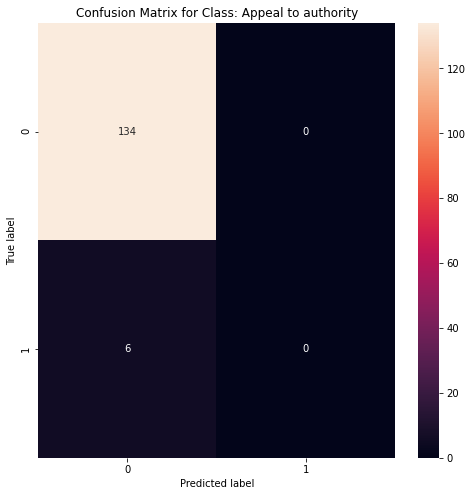

1


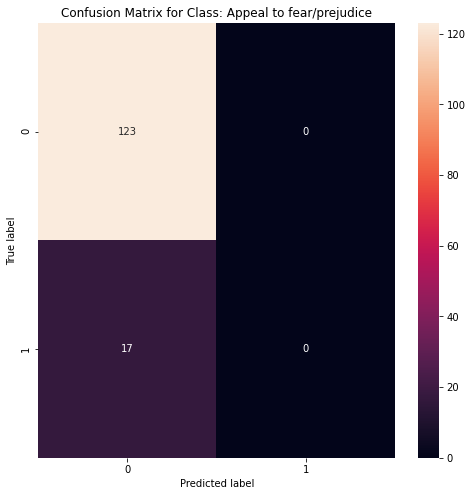

2


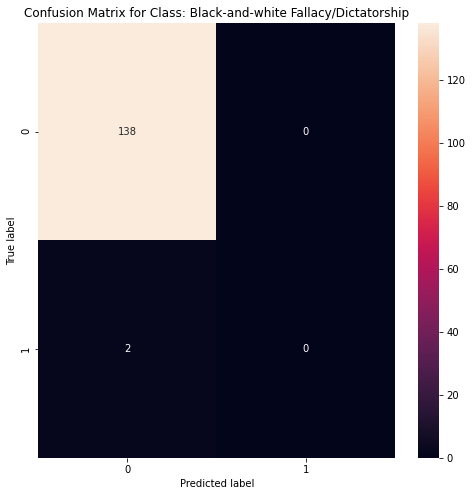

3


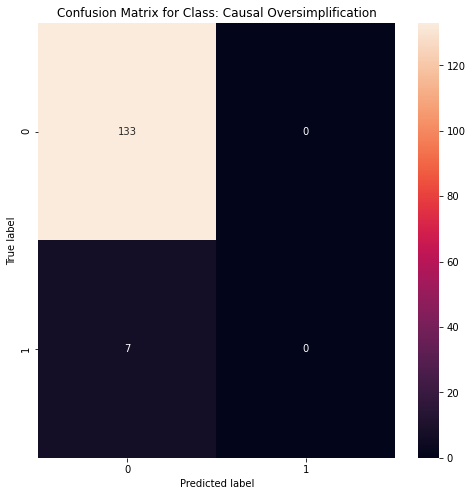

4


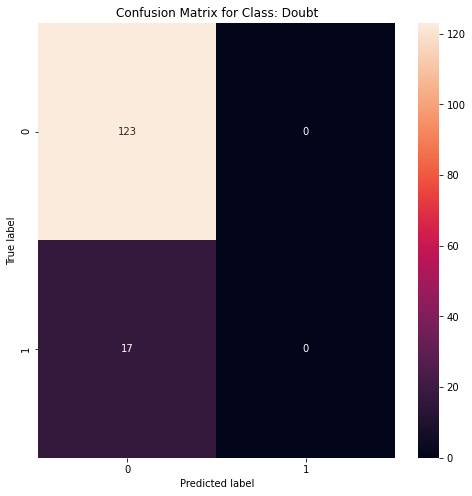

5


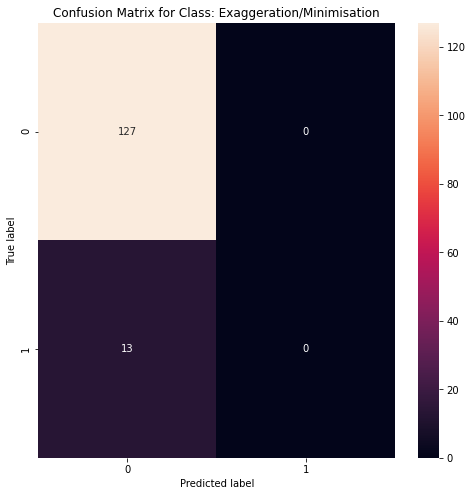

6


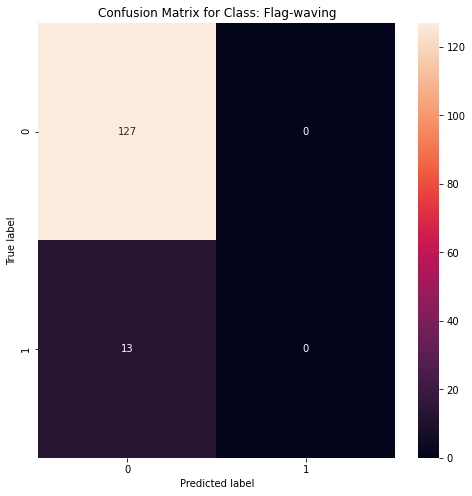

7


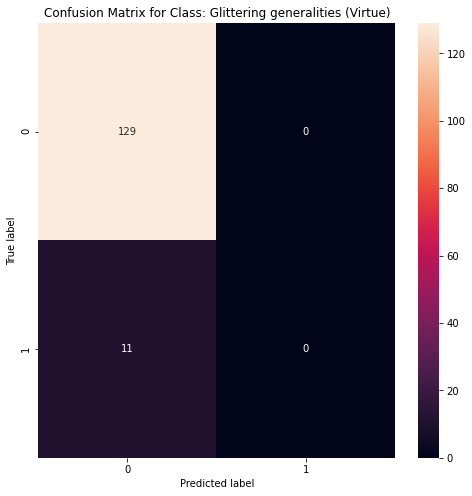

8


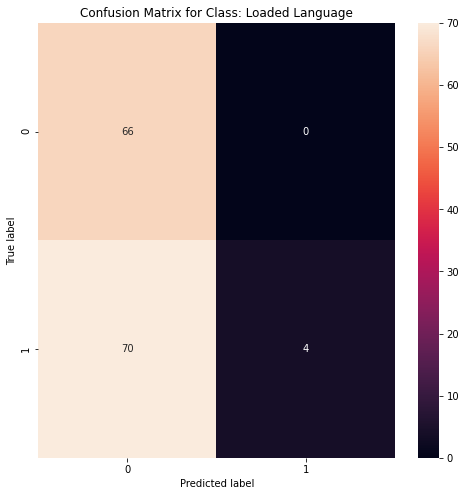

9


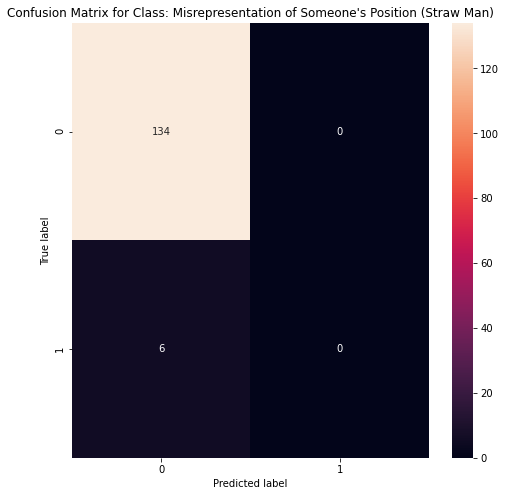

10


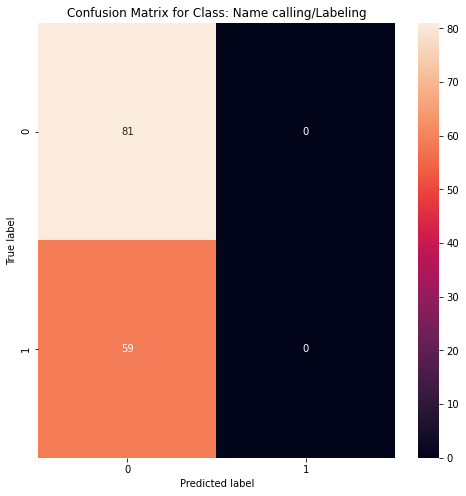

11


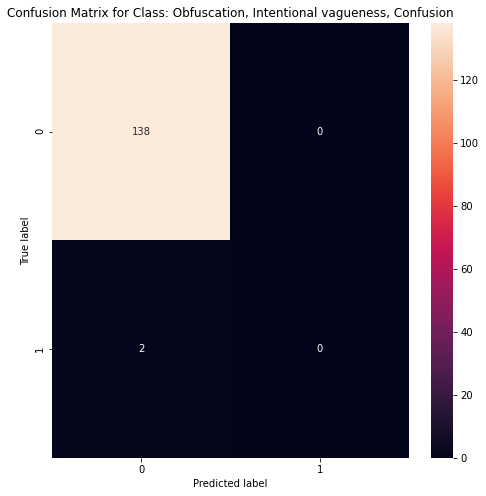

12


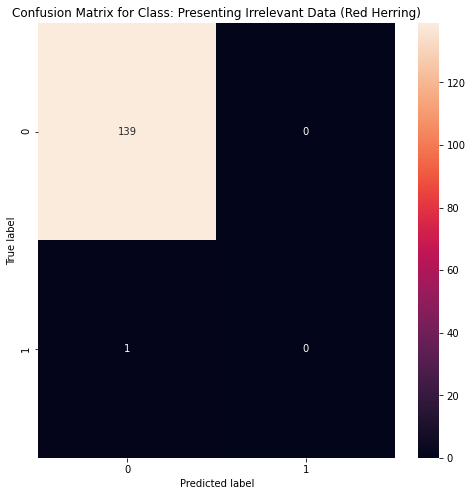

13


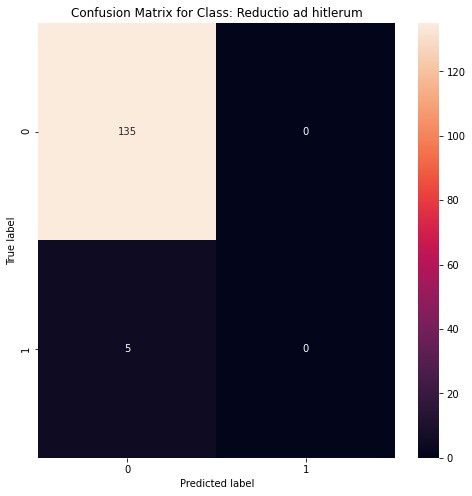

14


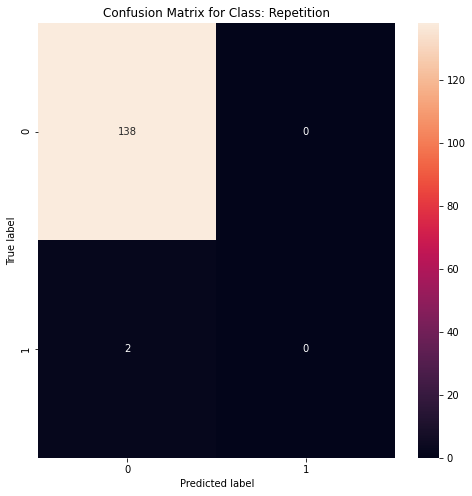

15


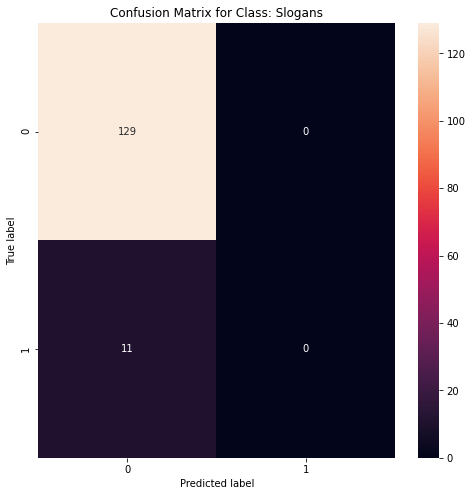

16


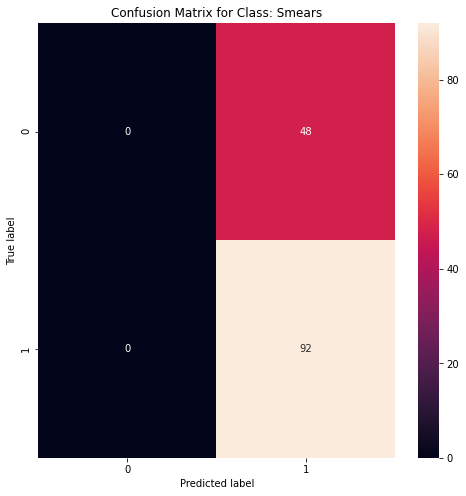

17


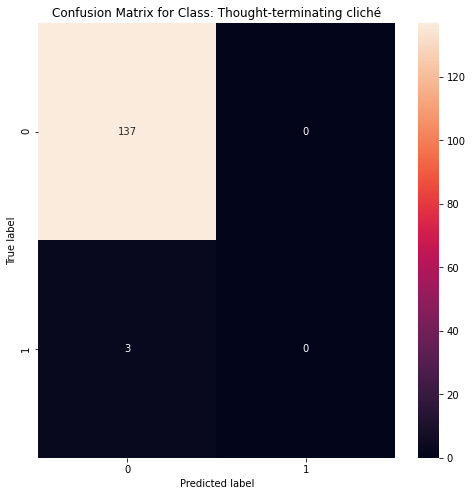

18


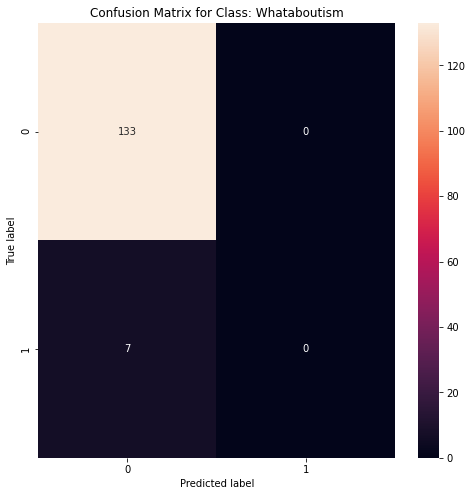

19


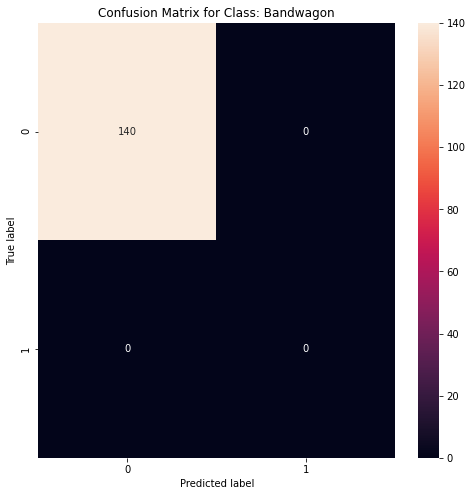

20


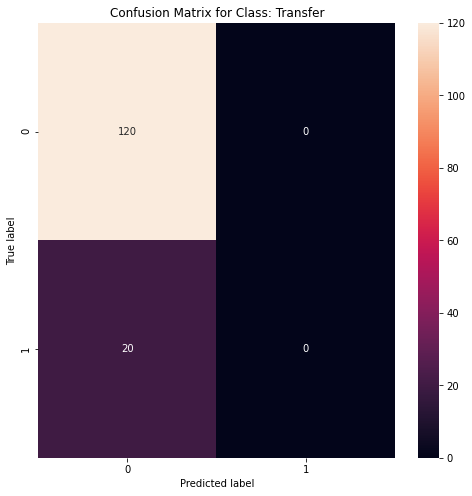

21


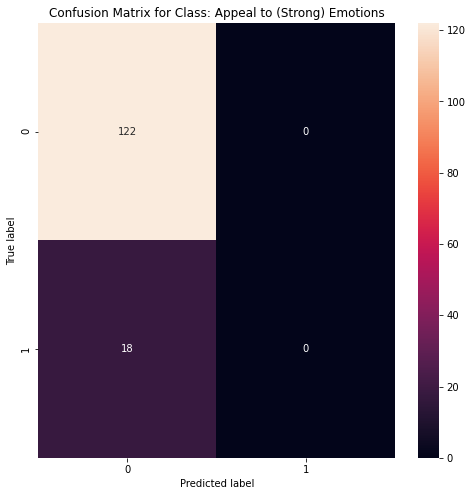

In [50]:
for i, class_cm in enumerate(ml_cm):
    if (i < 22):
        print(i)
        txt_title = "Confusion Matrix for Class: " + col[i] 
        # Transform to df for easier plotting
        plt.figure(figsize=(8,8))
        sns.heatmap(class_cm, annot=True, fmt='d')
        plt.title(txt_title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
